This notebook is my best scoring one for the [Kaggle 2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/overview), where I ended in the top 9% (310th place out of more than 3000 participants). The goal was to predict the attitude of children using a gaming application, based on their past actions.

It was my first real Kaggle competition, and I have learnt a lot of things from this work. The data was very complex to manipulate, and I have created many features for the competition, trying to see if some children were helped by their parents, if some devices were shared among different children, detection of particular events during the sessions, etc. At last, many of them didn't improve my score, but it was very interesting to work on such a project. I have used a Light GBM Regressor model with Cross-Validation, although the final goal was to assign to each children a category (no errors, 1 error, 2+ errors or can't finish the game). This surprising approach was confirmed by many of my predictions, and it turned out to be the good one!

Some functions may come from other notebooks, I have tried to keep the best of the publicly shared works and my own research.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm_notebook

pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import CatBoostRegressor, CatBoostClassifier
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn import linear_model
import gc
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

from tqdm import tqdm_notebook as tqdm

from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from joblib import Parallel, delayed

Using TensorFlow backend.


## Helper functions and classes

As the data was complex and came from different sources, a huge pre-processing part was needed to work on the data:

In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    return train, test, train_labels, specs, sample_submission

train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Reading test.csv file....
Reading train_labels.csv file....
Reading specs.csv file....
Reading sample_submission.csv file....


In [3]:
def encode_title(train, test, train_labels):
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))

    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    world_labels = dict(zip(np.arange(len(list_of_worlds)), list_of_worlds))
    
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110

    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, list_of_worlds, world_labels

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, list_of_worlds, world_labels = encode_title(train, test, train_labels)


In [5]:
def get_data(user_sample, test_set=False):
    # Constants and parameters declaration
    last_title = ""
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0,
                             'dayofweek': user_sample.iloc[0]['timestamp'].dayofweek,
                             'sin_hour': np.sin(2*np.pi*user_sample.iloc[0]['timestamp'].hour/24),
                             'cos_hour': np.cos(2*np.pi*user_sample.iloc[0]['timestamp'].hour/24)}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    accumulated_time_code_count: Dict[str, list] = {ev: [] for ev in list_of_event_code}
    accumulated_std_code_count: Dict[str, list] = {ev: [] for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
#     world_count: Dict[str, int] = {eve: 0 for eve in world_labels.values()} 
     
    
    assessment_codes = [2000, 2025, 3010, 3110, 4025, 3021, 3121, 4070, 2035, 2020, 4030, 4020, 4040, 4100, 2030, 2010, 4110, 3020, 3120, 4035, 4090, 4080]
    worlds = {0:0, 1:0, 2:0, 3:0}   
    last_assessment_played = {}
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_world = session['world'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
#             features.update(world_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session['title'].iloc[0]
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            
            # Targets for regressions
            features['TAR_true'] = true_attempts
            features['TAR_false'] = false_attempts
            
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts

            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
      
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            features['accumulated_actions'] = accumulated_actions
            
            #Added features
            if session_title in last_assessment_played:
                features['last_time_played'] = (session.iloc[0, 2] - last_assessment_played[session_title]).seconds
            else:
                features['last_time_played'] = 0
            last_assessment_played[session_title] = session.iloc[-1, 2]
            
            
#             for code in accumulated_time_code_count:
#                 flat_list = [item for sublist in accumulated_time_code_count[code] for item in sublist]
#                 features['avg_time_{}'.format(code)] = np.mean(flat_list) / 10 ** 9
#                 features['std_time_{}'.format(code)] = np.std(flat_list) #/counter if counter > 0 else 0
            
#             for code in assessment_codes:
#                 all_attempts = session.query(f'event_code == {code}')['timestamp'].diff()
#                 if len(all_attempts) > 1:
#                     accumulated_time_code_count[code].append(all_attempts.dropna().values.astype(np.int64))
    
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    if col == 'world':
                        x = world_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
#         world_count = update_counters(world_count, 'world')

        accumulated_actions += len(session)
        if last_title != session_title:
            user_activities_count[session_type] += 1
            last_title = session_title 
        worlds[session_world] += 1
                        
    if test_set:
        return all_assessments[-1]
    return all_assessments

In [6]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

# get usefull dict with maping encode
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

In [7]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

## Model fitting

I have tried many type of models and algorithms to have the best score (LGBM, Catboost, XGB, SVMs, ...). The model used is a LGBM Regressor with a 5-fold cross-validation, trying to predict the number of errors a child will make on the assessment. Then, I assign to each child its corresponding category.

In [8]:
all_features = [x for x in reduce_train.columns if x not in ['accuracy_group', 'installation_id', 'game_session', 'TAR_true', 'TAR_false']]
cat_features = [ 'session_title', 'dayofweek'] 
X, y, y_true, y_false = reduce_train[all_features], reduce_train['accuracy_group'], reduce_train['TAR_true'], reduce_train['TAR_false']

In [9]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [10]:
oof = np.zeros(len(X))
models = []
uncorrect_attempts = np.zeros(len(X))
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2506)
importances = []
training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f'Training on fold {fold+1}')
    
    lgbm = lgb.LGBMRegressor(n_estimators = 2000,
            boosting_type = 'gbdt',
            objective = 'regression',
            metric = 'rmse',
            eval_metric = 'cappa', # eval_qwk_lgb_regr not working
            subsample = 0.75,
            subsample_freq = 1,
            learning_rate = 0.04,
            feature_fraction = 0.9,
            max_depth = 15,
            lambda_l1 = 1,  
            lambda_l2 = 1,
            verbose = 100,
            early_stopping_rounds = 100)
    lgbm.fit(X.loc[trn_idx, all_features], 
              y.loc[trn_idx], 
              categorical_feature = cat_features,
              eval_set = (X.loc[test_idx, all_features], y.loc[test_idx]),
              verbose = 200)
    models.append(lgbm)
    importances.append(lgbm.feature_importances_)
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
oof = sum([model.predict(X[all_features]) for model in models])/NFOLDS
    
#     preds = lgbm.predict(X.loc[test_idx, all_features])
#     oof[test_idx] = preds

Training on fold 1
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.978719
[400]	valid_0's rmse: 0.979801
Early stopping, best iteration is:
[314]	valid_0's rmse: 0.977407
Fold 1 finished in 0:00:30.488899
Training on fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.984535
Early stopping, best iteration is:
[292]	valid_0's rmse: 0.982856
Fold 2 finished in 0:00:29.053246
Training on fold 3
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.988806
Early stopping, best iteration is:
[151]	valid_0's rmse: 0.987636
Fold 3 finished in 0:00:20.085213
Training on fold 4
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 0.984136
[400]	valid_0's rmse: 0.98395
Early stopping, best iteration is:
[345]	valid_0's rmse: 0.981827
Fold 4 finished in 0:00:32.368624
Training on fold 5
Training until validation scores don't improve for 100 rounds
[200]	vali

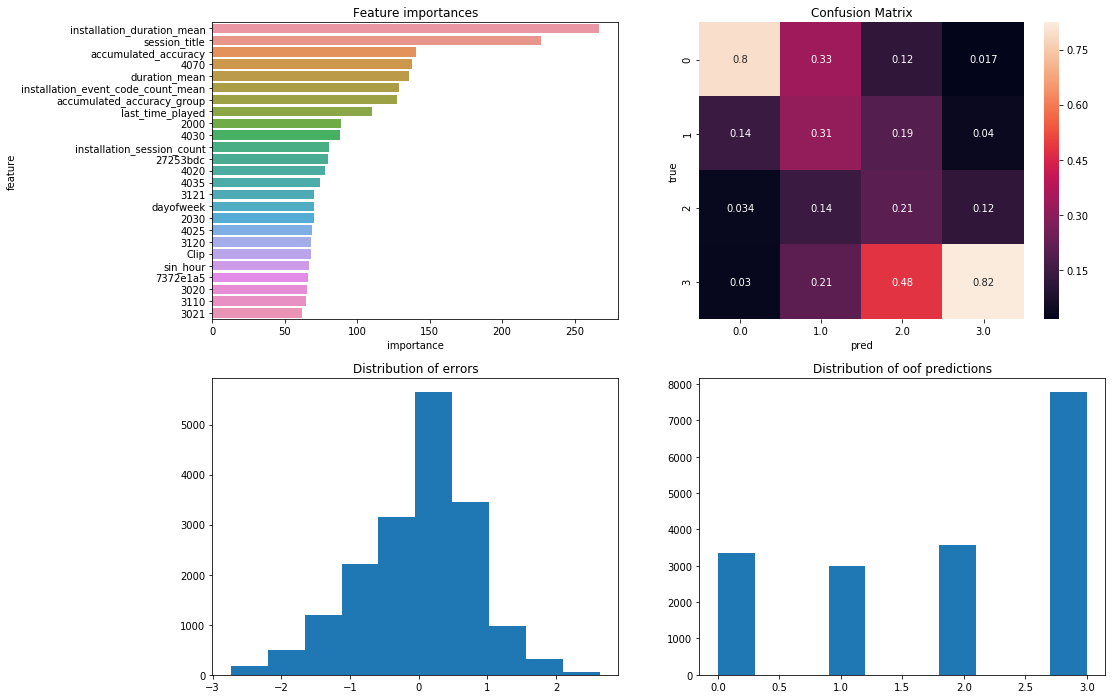

In [11]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = all_features
feat_imp['importance'] = [sum(i)/5 for i in zip(*importances)]

new_df = pd.DataFrame()
new_df['pred'] = oof
new_df['true'] = y
coefficients = [1.01530137, 1.74520658, 2.26012457]
new_df.loc[new_df['pred'] <= coefficients[0], 'pred'] = 0
new_df.loc[((new_df['pred'] > coefficients[0]) & (new_df['pred'] <= coefficients[1])), 'pred'] = 1
new_df.loc[((new_df['pred'] > coefficients[1]) & (new_df['pred'] <= coefficients[2])), 'pred'] = 2
new_df.loc[new_df['pred'] > coefficients[2], 'pred'] = 3

fig, ax = plt.subplots(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.barplot(x = 'importance', y = 'feature', data= feat_imp.sort_values(by = 'importance', ascending = False)[:25])
plt.title('Feature importances')

plt.subplot(2, 2, 2)
table = pd.pivot_table(new_df[['pred', 'true']], index = 'true', columns = 'pred', aggfunc = len)
for i in range(4):
    table[i] = table[i]/ np.sum(table[i])
sns.heatmap(table, annot = True)
plt.title('Confusion Matrix')

plt.subplot(2, 2, 3)
plt.hist(y - oof)
plt.title('Distribution of errors')

plt.subplot(2, 2, 4)
plt.hist(new_df['pred'])
plt.title('Distribution of oof predictions');

The metric used for the competition was a quadratic weighted Kappa, which is quite rare and complex. I took the following functions from Stack Overflow to implement it in the notebook.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True



def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


In [13]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']
    
# pr1 = lgbm.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(oof, y)
coefficients = optR.coefficients()

In [14]:
coefficients

array([1.11436203, 1.73993321, 2.26235231])

In [15]:
opt_preds = optR.predict(oof, coefficients)
qwk(y, opt_preds)

0.7445194126887615

In [16]:
pr1 = sum([model.predict(reduce_test[all_features]) for model in models])/NFOLDS
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3

In [17]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [18]:
sample_submission['accuracy_group'].value_counts(normalize=True)

2    0.321
3    0.320
0    0.180
1    0.179
Name: accuracy_group, dtype: float64